In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_one'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fa00817ef60> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fa0081703c8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.599    |
| time/              |          |
|    fps             | 80       |
|    iterations      | 1        |
|    time_elapsed    | 31       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 58 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.604       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 50 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.624       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011346236 |
|    clip_fraction        | 0.328       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.735       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0784      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0291     |
|    std                  | 

policy iteration runtime: 49 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.645       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008537429 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0847      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.029      |
|    std                  | 0.055       |
|    val

policy iteration runtime: 48 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.662       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007150608 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.822       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0637      |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.03       |
|    std                  |

policy iteration runtime: 50 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.67        |
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007624647 |
|    clip_fraction        | 0.34        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.83        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0497      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 57 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005715984 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.84        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0629      |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 49 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.684        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0058897138 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.851        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0454       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0303      |
|    std

policy iteration runtime: 58 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.691      |
| time/                   |            |
|    fps                  | 86         |
|    iterations           | 1          |
|    time_elapsed         | 29         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00541268 |
|    clip_fraction        | 0.368      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.855      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0394     |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0322    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 48 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007283074 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.861       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0681      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0307     |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004612854 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.871       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0428      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0297     |
|    std                  |

policy iteration runtime: 46 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.694        |
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072387517 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.869        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.08         |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.03        |
|    std                  | 0.

policy iteration runtime: 54 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 1           |
|    time_elapsed         | 28          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009494552 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.875       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0303      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0339     |
|    std                  |

policy iteration runtime: 47 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004196805 |
|    clip_fraction        | 0.395       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0524      |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0325     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 49 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008993214 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.877       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.101       |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0316     |
|    std                  |

policy iteration runtime: 55 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008157283 |
|    clip_fraction        | 0.349       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.864       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0517      |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0288     |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007531807 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.876       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0516      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0309     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 48 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 88           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075154724 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.876        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.071        |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.0311      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075871795 |
|    clip_fraction        | 0.378        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.887        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0335       |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.0308      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056215883 |
|    clip_fraction        | 0.37         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.881        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.061        |
|    n_updates            | 2900         |
|    policy_gradient_loss | -0.0309      |
|    std                  | 0.

<IPython.core.display.Javascript object>


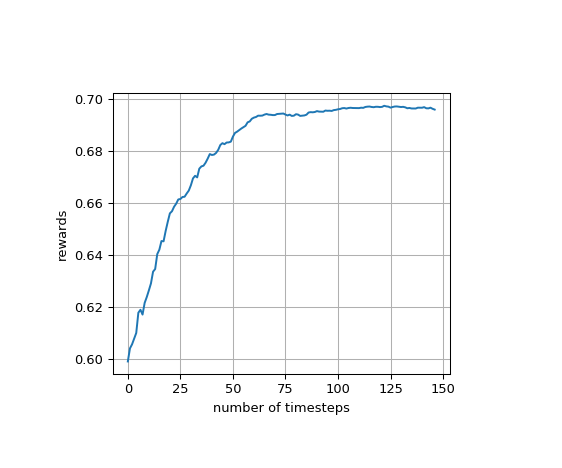

Using cuda device
seed 2: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9f8c0ca9b0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f9f783b6080>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.605       |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 1           |
|    time_elapsed         | 31          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004729694 |
|    clip_fraction        | 0.383       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0661      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0303     |
|    std                  | 0.0549      |
|    value_loss           | 0.00405     |
------------

policy iteration runtime: 50 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.628       |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.014184684 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.74        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0531      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0277     |
|    std                  | 

policy iteration runtime: 49 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.647       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011487303 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0793      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0289     |
|    std                  | 

policy iteration runtime: 51 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.669       |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007658729 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.806       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0709      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0279     |
|    std                  |

policy iteration runtime: 51 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.676       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005193436 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.821       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0431      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.03       |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008485404 |
|    clip_fraction        | 0.349       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.842       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0473      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 50 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006344557 |
|    clip_fraction        | 0.341       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.844       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0849      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0301     |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006100881 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.843       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0373      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0301     |
|    std                  |

policy iteration runtime: 48 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.693        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0040760785 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0518       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0305      |
|    std                  | 0.

policy iteration runtime: 53 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0053093107 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.852        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0544       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0306      |
|    std

policy iteration runtime: 50 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004631457 |
|    clip_fraction        | 0.355       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.867       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0632      |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0311     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 51 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049306513 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.872        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0506       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0294      |
|    std                  | 0.

policy iteration runtime: 48 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007907823 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.878       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0429      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 53 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 1           |
|    time_elapsed         | 35          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008025694 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.865       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0441      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 50 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.698     |
| time/                   |           |
|    fps                  | 83        |
|    iterations           | 1         |
|    time_elapsed         | 30        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0100268 |
|    clip_fraction        | 0.372     |
|    clip_range           | 0.1       |
|    entropy_loss         | 91.8      |
|    explained_variance   | 0.876     |
|    learning_rate        | 3e-06     |
|    loss                 | 0.0604    |
|    n_updates            | 2240      |
|    policy_gradient_loss | -0.0311   |
|    std                  | 0.0551    |
|    value_loss           | 0.00425   |
-------

policy iteration runtime: 50 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008283958 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.871       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0437      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0307     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 49 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0041592093 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.88         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.078        |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.0282      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0051862923 |
|    clip_fraction        | 0.377        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.88         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.065        |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.0309      |
|    std                  | 0.

policy iteration runtime: 50 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070198565 |
|    clip_fraction        | 0.374        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.882        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.047        |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0307      |
|    std                  | 0.

<IPython.core.display.Javascript object>


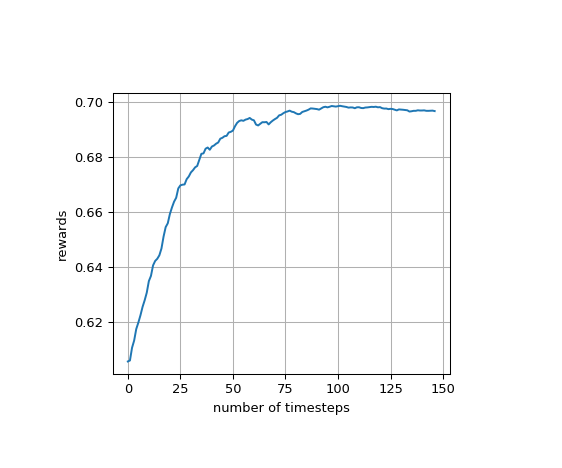

Using cuda device
seed 3: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fa009d9eb38> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fa008170e48>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.603        |
| time/                   |              |
|    fps                  | 80           |
|    iterations           | 1            |
|    time_elapsed         | 31           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075347004 |
|    clip_fraction        | 0.382        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.883        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.063        |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.0316      |
|    std                  | 0.0551       |
|    value_loss           | 0.0042

policy iteration runtime: 49 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.618       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010049412 |
|    clip_fraction        | 0.334       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.71        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0504      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0268     |
|    std                  | 

policy iteration runtime: 57 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.638        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066608014 |
|    clip_fraction        | 0.33         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.799        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0357       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0266      |
|    std 

policy iteration runtime: 52 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.657      |
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 1          |
|    time_elapsed         | 30         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00877876 |
|    clip_fraction        | 0.337      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.7       |
|    explained_variance   | 0.823      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0861     |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0283    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 50 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.671       |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005642521 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.832       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0707      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0285     |
|    std                  |

policy iteration runtime: 50 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.012488911 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.855       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.06        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.031      |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 51 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007242352 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.853       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0464      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0291     |
|    std                  |

policy iteration runtime: 52 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.691        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056981593 |
|    clip_fraction        | 0.344        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0565       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0285      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.692        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0043312134 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0795       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0297      |
|    std

policy iteration runtime: 50 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0035557866 |
|    clip_fraction        | 0.356        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.869        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0561       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0299      |
|    std

policy iteration runtime: 50 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070402147 |
|    clip_fraction        | 0.338        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.863        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0711       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0288      |
|    std                  | 0.

policy iteration runtime: 50 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0043393164 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.871        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0566       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0307      |
|    std

policy iteration runtime: 50 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008912978 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.873       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.071       |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0301     |
|    std                  |

policy iteration runtime: 50 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.002268222 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.888       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0431      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0307     |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.699      |
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 1          |
|    time_elapsed         | 30         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00873563 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.883      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0658     |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0295    |
|    std                  | 0.055      |
|    

policy iteration runtime: 50 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0052012233 |
|    clip_fraction        | 0.356        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.882        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0339       |
|    n_updates            | 2400         |
|    policy_gradient_loss | -0.029       |
|    std                  | 0.

policy iteration runtime: 50 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0055874498 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0501       |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.03        |
|    std                  | 0.

policy iteration runtime: 51 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067432136 |
|    clip_fraction        | 0.357        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.897        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0519       |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.0291      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070595876 |
|    clip_fraction        | 0.373        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0718       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0299      |
|    std                  | 0.

<IPython.core.display.Javascript object>


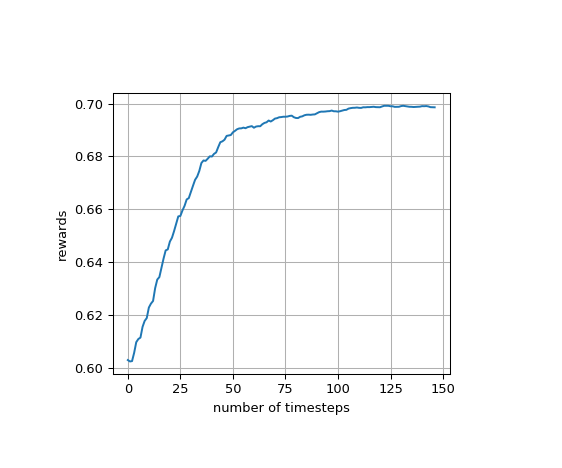

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[1.0],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)